# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

You can use split_input_df to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [7]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, val_split_ratio=0.1, test_split_ratio=0.1)

Prepending /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [8]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [9]:
train_df.head(5)

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [10]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


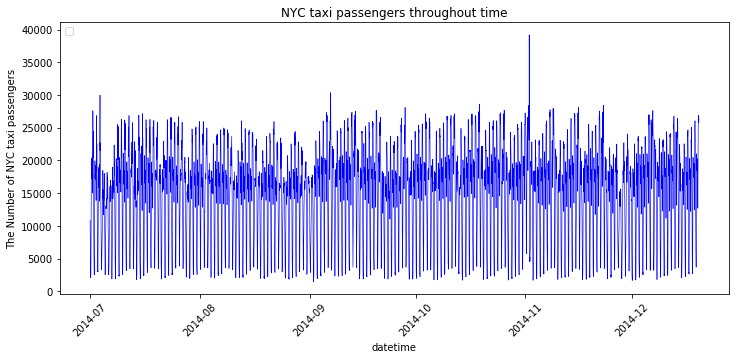

In [11]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. 

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value','extra_features'\].  

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`. The previous sequence length will be considered as a tunable variable in our future version.

In [12]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [13]:
from zoo import init_spark_on_local
from zoo.ray.util.raycontext import RayContext
sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc)
ray_ctx.init()

Current pyspark location is : /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched
Start to launch ray on cluster
Start to launch ray on local


In [14]:
ray_ctx.init()

Start to launch ray on cluster
Start to launch ray on local


In [15]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mean_squared_error")
print("Training completed.")

2019-08-30 18:12:34,932	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-08-30 18:12:34,933	INFO tune.py:223 -- Starting a new experiment.


Model selection: Vanilla LSTM model is selected.
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs (0/2.0 ps, 0/2.0 trainer)
Memory usage on this node: 29.7/270.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs (0/2.0 ps, 0/2.0 trainer)
Memory usage on this node: 29.7/270.4 GB
Result logdir: /root/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_dropout_1=0.37899,dropout_2=0.25233,lstm_1_units=64,lstm_2_units=64:	RUNNING

(pid=25880) Prepending /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=25924) Prepending /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=25925) Prepending /opt/work/client/yushan/bin/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=25925) Prepend

Training completed.
CPU times: user 4.31 s, sys: 416 ms, total: 4.72 s
Wall time: 15.7 s


## 3. Test

In [16]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [17]:
pred_df.head(5)

,datetime,value
0,2015-01-10 12:30:00,21807.587891
1,2015-01-10 13:00:00,22835.722656
2,2015-01-10 13:30:00,22133.761719
3,2015-01-10 14:00:00,21599.056641
4,2015-01-10 14:30:00,20513.060547


In [18]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


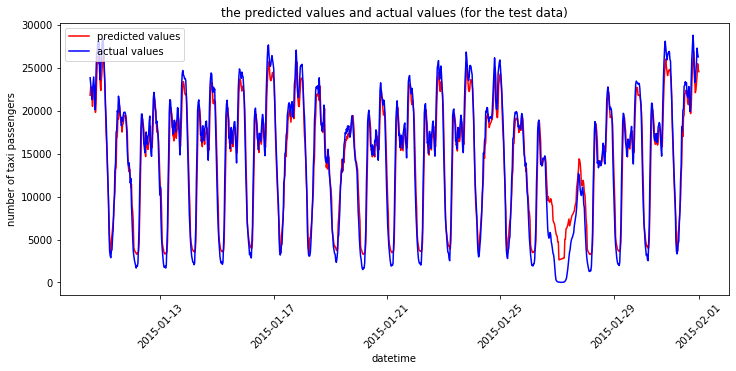

In [19]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

In [20]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metrics=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is [3338194.10975757]
Evaluate: the r_squared value is [0.94127016]


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [21]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


In [22]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

Restore pipeline from /tmp/saved_pipeline/my.ppl


In [23]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [24]:
new_pred.head(5)

,datetime,value
0,2015-01-10 12:30:00,21807.587891
1,2015-01-10 13:00:00,22835.722656
2,2015-01-10 13:30:00,22133.761719
3,2015-01-10 14:00:00,21599.056641
4,2015-01-10 14:30:00,20513.060547


In [25]:
# evaluate test_df
mse, rs = new_pipeline.evaluate(test_df, metrics=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_square value is", rs)

Evaluate: the mean square error is [3338194.10975757]
Evaluate: the r_square value is [0.94127016]


## 5. continue training

We support continue training with incremental data using the best configuration searched and the trained model.

In [26]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: datetime
target_col: value
extra_features_col: None
drop_missing: True



In [27]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Epoch 1/5
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0661 - mean_squared_error: 0.0661
Epoch 2/5
1031/1031 [==============================] - 0s 52us/step - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 3/5
1031/1031 [==============================] - 0s 37us/step - loss: 0.0550 - mean_squared_error: 0.0550
Epoch 4/5
1031/1031 [==============================] - 0s 46us/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5/5
1031/1031 [==============================] - 0s 59us/step - loss: 0.0540 - mean_squared_error: 0.0540
Fit done!


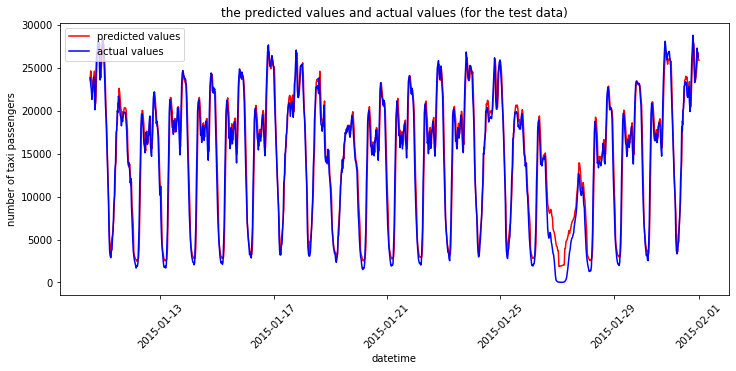

In [28]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df)

In [29]:
# evaluate test_df
mse, rs = new_pipeline.evaluate(test_df, metrics=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_square value is", rs)

Evaluate: the mean square error is [2684860.63745528]
Evaluate: the r_square value is [0.95276445]


## 6. multi step forecasting 

You can do multi step forecasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [30]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [31]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mean_squared_error",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

2019-08-30 18:13:01,639	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-08-30 18:13:01,640	INFO tune.py:223 -- Starting a new experiment.


Model selection: LSTM Seq2Seq model is selected.
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs (0/2.0 ps, 0/2.0 trainer)
Memory usage on this node: 30.2/270.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs (0/2.0 ps, 0/2.0 trainer)
Memory usage on this node: 30.2/270.4 GB
Result logdir: /root/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=64,dropout_1=0.248,dropout_2=0.25111,lr=0.006787,lstm_1_units=32,lstm_2_units=128,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_AWAKE(datetime)']:	RUNNING

(pid=25858) Model selection: LSTM Seq2Seq model is selected.
(pid=25858) Model selection: LSTM Seq2Seq model is selected.
(pid=25858) Model selection: LSTM Seq2Seq model is selected.
(pid=25858) 2019-08-30 18:13:07.453015: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not c

In [32]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [33]:
pred_df.head(5)

,datetime,value_0,value_1,value_2,value_3,value_4
0,2015-01-10 17:00:00,19613.948629,19338.041123,18425.333485,16770.234847,14860.002380
1,2015-01-10 17:30:00,21429.083095,20962.618339,19427.684983,16917.337746,14085.563665
2,2015-01-10 18:00:00,23475.641653,22394.491709,20396.785120,17599.133980,14536.517919
3,2015-01-10 18:30:00,24504.600751,22765.059582,20548.217870,17879.299047,14926.972582
4,2015-01-10 19:00:00,23845.314190,21796.702009,19724.627170,17174.323275,14258.633176


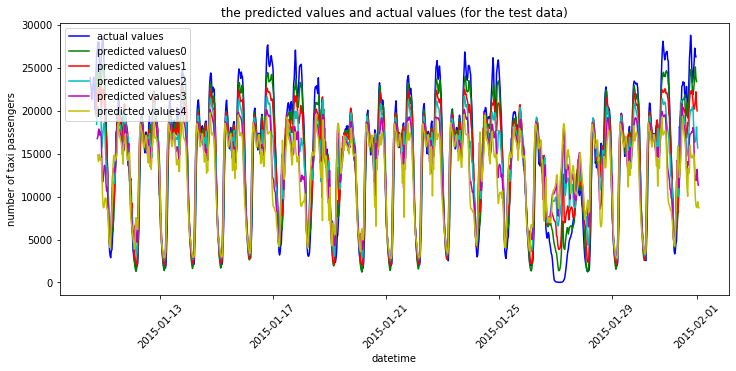

In [34]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df)

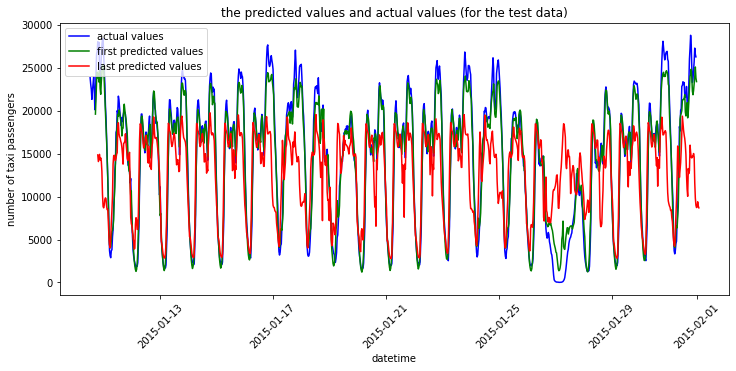

In [35]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df)

In [36]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metrics=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is [ 1915768.90010888  6102518.4759513  14208160.42343796 23397806.18587725
 32225509.93557186]
Evaluate: the r_squared value is [0.96605205 0.8920152  0.74887123 0.5864362  0.43025581]


In [37]:
ray_ctx.stop()

Stopping pgids: [25912, 25917]
Stopping by pgid 25912
Stopping by pgid 25917
